Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Чем больше `batch_size`, тем:
1. сложнее вычислить один градиент;
2. меньше итераций градиентного спуска в одной эпохе;
3. выше точность вычисления градиента (по сравнению с вычислением на полном наборе данных), поэтому нужно меньше эпох для сходимости.

Полагаю, что пункты 1 и 2 друг друга более-менее уравновешивают, поэтому за счет пункта 3 скорость обучения будет выше при большем значении параметра.

Посмотрим на какую-нибудь картинку:

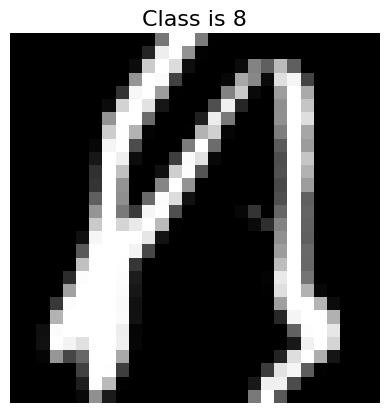

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





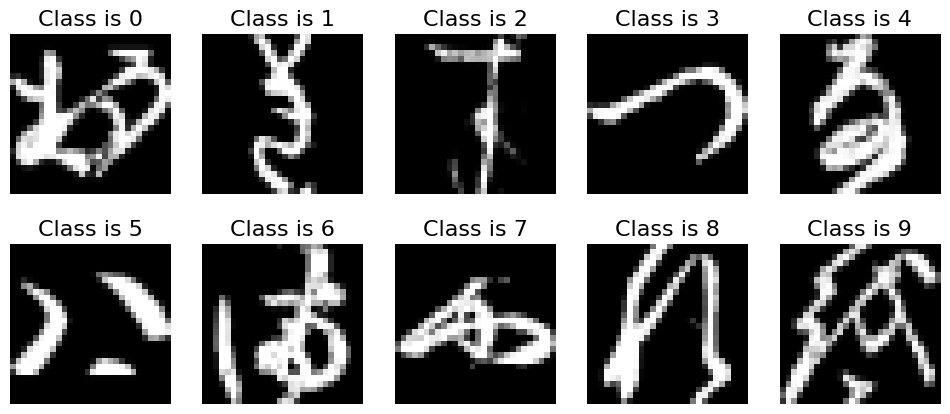

In [ ]:
indices = {}
n = 10
for i in range(len(trainset)):
    if trainset[i][1] not in indices:
        indices[trainset[i][1]] = i
        n -= 1
        if n == 0:
            break

plt.rcParams["figure.figsize"] = 12, 5

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(trainset[indices[i]][0].view(28, 28).numpy(), cmap="gray")
    plt.axis("off")
    plt.title(f"Class is {trainset[indices[i]][1]}", fontsize=16);

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self, activation=F.relu):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc2 = nn.Linear(in_features=256, out_features=128)

        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=128, out_features=10)        

        self.activation = activation

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [ ]:
layer1 = (28 * 28 + 1) * 256
layer2 = (256 + 1) * 128
layer3 = (128 + 1) * 10
answer = layer1 + layer2 + layer3
print(answer)

235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 3e-4 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9149
Epoch=2 loss=0.4478
Epoch=3 loss=0.3507
Epoch=4 loss=0.2934
Epoch=5 loss=0.2505
Epoch=6 loss=0.2176
Epoch=7 loss=0.1886
Epoch=8 loss=0.1647
Epoch=9 loss=0.1449
Epoch=10 loss=0.1276


In [ ]:
get_accuracy(fc_net, testloader)

0.8726

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
n = len(trainset)

mean = 0
for i in range(len(trainset)):
    mean += trainset[i][0].sum()
mean /= n * 28 * 28

std = 0
for i in range(len(trainset)):
    std += ((trainset[i][0] - mean) ** 2).sum()
std /= n * 28 * 28
std **= 0.5

print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6878
Epoch=2 loss=0.3037
Epoch=3 loss=0.2234
Epoch=4 loss=0.1742
Epoch=5 loss=0.1404
Epoch=6 loss=0.1134
Epoch=7 loss=0.0933
Epoch=8 loss=0.0773
Epoch=9 loss=0.0626
Epoch=10 loss=0.0508


In [ ]:
get_accuracy(fc_net, testloader)

0.8987

Как изменилась `accuracy` после нормализации?

Немного увеличилась, примерно на 0.02 :)

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
## YOUR CODE HERE

activations = [["Sigmoid", F.sigmoid], ["GELU", F.gelu], ["Tanh", F.tanh]]
fc_nets = []
optimizers = []
loss_functions = []
lr = 3e-4

for activation in activations:
    fc_nets.append(FCNet(activation=activation[1]))
    optimizers.append(torch.optim.Adam(fc_nets[-1].parameters(), lr=lr))
    loss_functions.append(nn.CrossEntropyLoss())


In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
import time
duration = [0] * 3

for epoch in range(n_epochs):
    epoch_loss = torch.zeros(3)
    for images, labels in trainloader:
        for i in range(3):
            duration[i] -= time.time()

            optimizers[i].zero_grad() 
            outputs = fc_nets[i](images) 
            loss = loss_functions[i](outputs, labels) 
            loss.backward() 
            optimizers[i].step() 

            duration[i] += time.time()

            epoch_loss[i] += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"\nEpoch={epoch+1}")
    for i in range(3):
        print(activations[i][0], f"loss={loss_history[-1][i]:.4f}", f"  duration={duration[i]:.4f}")


Epoch=1
Sigmoid loss=0.7429   duration=3.5558
GELU loss=0.2855   duration=4.2472
Tanh loss=0.3873   duration=4.0000

Epoch=2
Sigmoid loss=0.5377   duration=7.5157
GELU loss=0.2077   duration=9.1251
Tanh loss=0.2631   duration=8.5606

Epoch=3
Sigmoid loss=0.4366   duration=11.1961
GELU loss=0.1590   duration=13.7529
Tanh loss=0.1887   duration=12.9700

Epoch=4
Sigmoid loss=0.3675   duration=14.8370
GELU loss=0.1241   duration=18.2441
Tanh loss=0.1392   duration=17.2540

Epoch=5
Sigmoid loss=0.3148   duration=18.3623
GELU loss=0.0995   duration=22.5363
Tanh loss=0.1050   duration=21.3325

Epoch=6
Sigmoid loss=0.2730   duration=23.0752
GELU loss=0.0799   duration=28.7847
Tanh loss=0.0785   duration=26.9468

Epoch=7
Sigmoid loss=0.2386   duration=27.9416
GELU loss=0.0637   duration=35.0959
Tanh loss=0.0582   duration=32.8539

Epoch=8
Sigmoid loss=0.2101   duration=32.1138
GELU loss=0.0505   duration=40.7593
Tanh loss=0.0434   duration=38.0598

Epoch=9
Sigmoid loss=0.1861   duration=36.748

In [ ]:
for i in range(3):
    print(activations[i][0], f"accuracy={get_accuracy(fc_nets[i], testloader):.4f}")

Sigmoid accuracy=0.8625
GELU accuracy=0.8983
Tanh accuracy=0.8973


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Лучший результат получился у GELU: 0.8983

Быстрее всех обучилась Sigmoid: 40.8638

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
## YOUR CODE HERE

opts= [["Adam", torch.optim.Adam], ["RMSprop", torch.optim.RMSprop], ["Adagrad", torch.optim.Adagrad]]
fc_nets = []
optimizers = []
loss_functions = []
lr = 3e-4

for opt in opts:
    fc_nets.append(FCNet(activation=F.gelu))
    optimizers.append(opt[1](fc_nets[-1].parameters(), lr=lr))
    loss_functions.append(nn.CrossEntropyLoss())

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
import time
duration = [0] * 3

for epoch in range(n_epochs):
    epoch_loss = torch.zeros(3)
    for images, labels in trainloader:
        for i in range(3):
            duration[i] -= time.time()

            optimizers[i].zero_grad() 
            outputs = fc_nets[i](images) 
            loss = loss_functions[i](outputs, labels) 
            loss.backward() 
            optimizers[i].step() 

            duration[i] += time.time()

            epoch_loss[i] += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"\nEpoch={epoch+1}")
    for i in range(3):
        print(opts[i][0], f"loss={loss_history[-1][i]:.4f}", f"  duration={duration[i]:.4f}")


Epoch=1
Adam loss=0.6728   duration=4.4912
RMSprop loss=0.4444   duration=4.6629
Adagrad loss=1.3448   duration=4.4457

Epoch=2
Adam loss=0.2891   duration=8.2684
RMSprop loss=0.2385   duration=8.6690
Adagrad loss=0.8223   duration=8.4041

Epoch=3
Adam loss=0.2096   duration=12.3317
RMSprop loss=0.1764   duration=12.8135
Adagrad loss=0.7004   duration=12.3349

Epoch=4
Adam loss=0.1599   duration=16.0937
RMSprop loss=0.1366   duration=16.4907
Adagrad loss=0.6383   duration=16.0306

Epoch=5
Adam loss=0.1261   duration=20.7514
RMSprop loss=0.1080   duration=21.5466
Adagrad loss=0.5980   duration=20.9688

Epoch=6
Adam loss=0.1018   duration=25.0053
RMSprop loss=0.0864   duration=25.7372
Adagrad loss=0.5689   duration=25.1478

Epoch=7
Adam loss=0.0819   duration=29.2808
RMSprop loss=0.0684   duration=30.2036
Adagrad loss=0.5460   duration=29.4566

Epoch=8
Adam loss=0.0660   duration=34.2951
RMSprop loss=0.0545   duration=35.7005
Adagrad loss=0.5270   duration=34.7512

Epoch=9
Adam loss=0.0

In [ ]:
for i in range(3):
    print(opts[i][0], f"accuracy={get_accuracy(fc_nets[i], testloader):.4f}")

Adam accuracy=0.9013
RMSprop accuracy=0.9004
Adagrad accuracy=0.7208


Лучший результат у Adam: 0.9013

Быстрее всех обучился Adam: 43.3461

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x[x < 0] = 0 
        return x

In [ ]:
print("Accuracy ReLU:", get_accuracy(fc_net, testloader))

Accuracy ReLU: 0.8987


In [ ]:
fc_net.activation = CustomReLU()
print("Accuracy CustomReLU:", get_accuracy(fc_net, testloader))

Accuracy CustomReLU: 0.8987


Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
fc_net = FCNet(activation=CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6869
Epoch=2 loss=0.3064
Epoch=3 loss=0.2229
Epoch=4 loss=0.1720
Epoch=5 loss=0.1369
Epoch=6 loss=0.1113
Epoch=7 loss=0.0909
Epoch=8 loss=0.0749
Epoch=9 loss=0.0602
Epoch=10 loss=0.0490


In [ ]:
print("Accuracy CustomReLU:", get_accuracy(fc_net, testloader))

Accuracy CustomReLU: 0.8962


### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

In [3]:
from PIL import Image

перспективный многогранник

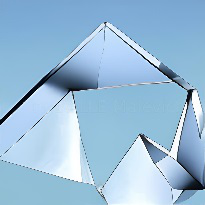

In [8]:
Image.open("1.jpg")

толстый и тонкий

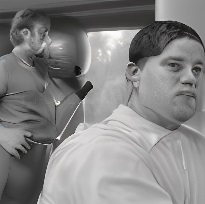

In [9]:
Image.open("2.jpg")

белая стрекоза любви

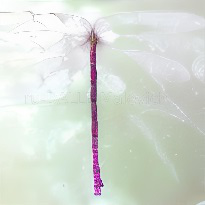

In [10]:
Image.open("3.jpg")